In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os,cv2,keras

In [25]:
X_new = np.load('/kaggle/input/nbgtyu/X_new.npy')
Y_new = np.load('/kaggle/input/nbgtyu/Y_new.npy')

In [26]:
from sklearn.utils import shuffle
X_new,Y_new = shuffle(X_new,Y_new,random_state = 20)
# X_new = X_new[:4000]
# Y_new = Y_new[:4000]

In [27]:
len(X_new),len(Y_new)

(4102, 4102)

In [29]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [30]:
# weights of VGG16 architecture is being used
vggmodel = VGG16(weights='imagenet', include_top=True)  # include_top adds a fully connected layer at the top
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
for layers in (vggmodel.layers)[:15]: # as there are 16 layers
  print(layers)
  layers.trainable = False  # the layers don't get trained


In [32]:
X = vggmodel.layers[-2].output

In [33]:
# predictions = Dense(1,activation='sigmoid')(X)
predictions = Dense(2,activation='softmax')(X) # removing the last layer and adding an output layer of 2 nodes

In [34]:
model_final = Model(vggmodel.input,predictions)

In [35]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
# it helps to create the complete model
# model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits= True), optimizer = opt,metrics = ['accuracy'])
model_final.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt,metrics = ['accuracy'])

In [37]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [39]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self,y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y,1-Y))
        else:
            return Y
  
    def inverse_transform(self,Y,threshold=None):
        if self.y_type_ == 'binary':
              return super().inverse_transform(Y[:,0],threshold)
        else:
              return super().inverse_transform(Y,threshold)

In [40]:
lenc = MyLabelBinarizer()
Y = lenc.fit_transform(Y_new)

In [41]:
from sklearn.utils import shuffle
X_final_train,Y_final_train = shuffle(X_new,Y,random_state = 20)

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X_final_train,Y_final_train,test_size=0.1,shuffle=True,stratify = Y_final_train)

In [43]:
batch_size = 512
nb_epoch = 10
steps_per_epoch = np.ceil(len(X_train)/batch_size)
validation_steps = np.ceil(len(X_test)/batch_size)

In [44]:
# # Doing Data Augmentation

trdata = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 90)
train_data = trdata.flow(x = X_train, y = Y_train)
tsdata = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 90)
test_data = tsdata.flow(x = X_test, y = Y_test)

In [45]:
def load_data(X_train,Y_train,idx,batch_size):
    st = idx*batch_size
    nrows = st+batch_size
    x = X_train[st:nrows]
    y = Y_train[st:nrows]
    return x,y

In [46]:
def batch_generator(X_train,Y_train,batch_size,steps):
    idx=1
    while True:
        yield load_data(X_train,Y_train,idx-1,batch_size)
        if idx<steps:
            idx += 1
        else:
            idx = 1

In [47]:
train_batch = batch_generator(X_train,Y_train,512,steps_per_epoch)
valid_batch = batch_generator(X_test,Y_test,512,validation_steps)

In [48]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [49]:
# For Creating Check Points
checkpoint = ModelCheckpoint("rcnn_vgg16_1_Final1.h5",monitor = 'val_loss',verbose=1, save_best_only = True, save_Weights_only = False, mode = 'auto', period = 1)

In [50]:
# For Early Stopping
early = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 2, verbose = 1, mode='auto')
# monitor is the metrics on which early stopping is dependent
# patience is the number of more epoches the model should continue to train when it detects that the
# "val_loss" is not decreasing further or increasing. After the patience no of epoch from that point
# where it detects, the execution of the model stops
# mode is the parameter which checks "min" or "max" of the metrics. In loss, it checks till the metrics reaches minimum

In [51]:
 # Training the model with fit_generator
hist = model_final.fit_generator(train_batch,epochs = nb_epoch,steps_per_epoch = steps_per_epoch,verbose=1,validation_data = valid_batch,validation_steps = validation_steps)
# hist = model_final.fit(x=X_train,y=Y_train, steps_per_epoch = none, epochs = 10, validation_data = (X_test,Y_test), validation_steps = 2, callbacks = [checkpoint,early])

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


8/8 [==============================] - 1446s 180s/step - loss: 1.2146 - accuracy: 0.6857 - val_loss: 0.3046 - val_accuracy: 0.8637
Epoch 2/10
8/8 [==============================] - 1445s 181s/step - loss: 0.1794 - accuracy: 0.9312 - val_loss: 0.1537 - val_accuracy: 0.9465
Epoch 3/10
8/8 [==============================] - 1455s 182s/step - loss: 0.0731 - accuracy: 0.9716 - val_loss: 0.1148 - val_accuracy: 0.9635
Epoch 4/10
8/8 [==============================] - 1470s 182s/step - loss: 0.0279 - accuracy: 0.9902 - val_loss: 0.1049 - val_accuracy: 0.9708
Epoch 5/10
8/8 [==============================] - 1462s 183s/step - loss: 0.0172 - accuracy: 0.9935 - val_loss: 0.0905 - val_accuracy: 0.9805
Epoch 6/10
8/8 [==============================] - 1453s 182s/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.0952 - val_accuracy: 0.9805
Epoch 7/10
8/8 [==============================] - 1463s 182s/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.1170 - val_accuracy: 0.9781
Epoch 8/10
8/8 [=

In [54]:
model_final.save("rcnn_vgg16_1_Final1_new.h5")

In [55]:
model_final.save_weights("rcnn_vgg16_Final_Weights_new.h5")

In [57]:
from IPython.display import FileLink
FileLink(r'rcnn_vgg16_Final_Weights_new.h5')

/kaggle/working/rcnn_vgg16_Final_Weights_new.h5

In [58]:
from IPython.display import FileLink
FileLink(r'rcnn_vgg16_1_Final1_new.h5')

/kaggle/working/rcnn_vgg16_1_Final1_new.h5

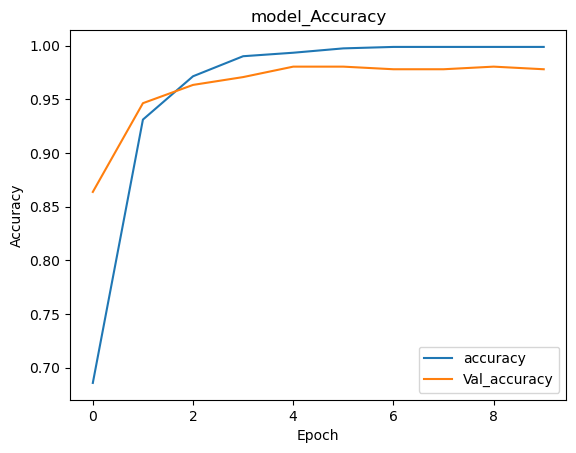

In [59]:
# For visualizing different loss
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model_Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy','Val_accuracy'])
plt.show()